In [1]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as ticker

In [2]:
# Simulacion y archivo de datos

simu='RefL0100N1504'
snap='28'

folder='/home/ramiro/Facultad/Tesis/Python/Actividad 6/'
file_table='Aperturas_'+simu+'_snap_'+snap+'_aperture_30.dat'
path_data=folder+file_table

raw_data=ascii.read(path_data)

In [3]:
# Definir nuevas variables, si es necesario
raw_data['sSFR']=raw_data['StarFormationRate']/raw_data['Stars_Mass']
raw_data['SF_Frac']=raw_data['SF_Mass']/(raw_data['SF_Mass']+raw_data['Stars_Mass'])
raw_data['Baryonic_Mass']=raw_data['Stars_Mass']+raw_data['SF_Mass']+raw_data['NSF_Mass']

In [4]:
SF_O  = raw_data['SF_Oxygen']
SF_H  = raw_data['SF_Hydrogen']
SF_M  = raw_data['SF_Mass']
M_Star= raw_data['Stars_Mass']

M_O_SF = SF_O*SF_M
M_H_SF = SF_H*SF_M

raw_data['sf_metalicity'] = 12+np.log10(M_O_SF/(16*M_H_SF))

<ipython-input-4-f96a78f7c5a2>:9: RuntimeWarning: invalid value encountered in true_divide
  raw_data['sf_metalicity'] = 12+np.log10(M_O_SF/(16*M_H_SF))


In [13]:
# Condiciones para seleccionar muestra
mask=((raw_data['Stars_Mass']>=1e9) & (raw_data['StarFormationRate']>0) & 
      (raw_data['SF_Mass']>0) )

data={}
for key in raw_data.keys():
    data[key]=raw_data[key][mask]

In [14]:
# Variables (ejes) a graficar
xplot=np.log10(data['Stars_Mass'])
yplot=data['sf_metalicity']

xlabel=r'$\log(M_\bigstar)~[\rm{M}_\odot]$'
ylabel=r'$12+log(M_{O}/M_{H})$'

In [11]:
#-------------------- Variables para pintar grilla 2D-----------------------------------------------
# Variable a usar para colorear
var_color=data['SnapNum']

# Estadístico a usar ('counts','mean','median')
statistic='median'

# 'counts' es para contar el número de galaxias en cada bin (digamos, es para hacer un histograma2D)
# 'mean' y 'median' son para calcular la media o la mediana de var en cada bin.
           
# Label to use in color bar reference
var_label=r'$\log(SFR)~[\rm{M}_\odot ~ \rm{yr}^{-1}]$'

# Número de bines en cada eje
nbinsx=40
nbinsy=30
    
# Minimum number of galaxies to color bin (bins with less galaxies than this value will
# not be taken into account)
cmin=5

# Color map to use. Use 'mapname_r' to invert colours. For example, if want to
# invert the color map "jet", use "jet_r".
cmap='jet_r'

<ipython-input-12-ea6555f64f99>:79: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet_r"))
  cmap.set_under('white')                      # "bad-defined" bins will be of colour white.


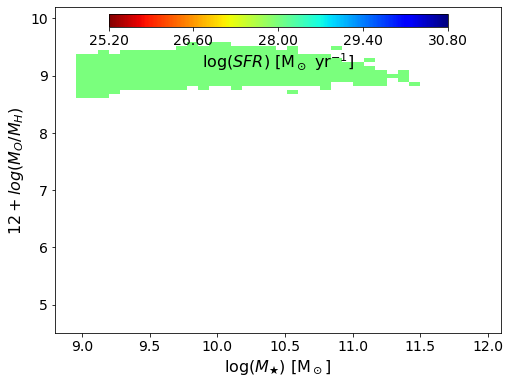

In [12]:
# Plot color map
fig,ax=plt.subplots(figsize=(8,6))

# Intervals of binning, as function of nbinsx and nbinsy:
intx=(max(xplot)-min(xplot))/nbinsx
inty=(max(yplot)-min(yplot))/nbinsy

# If 'var_color' is an empty sequence or 'statistic=='counts'', plot a 2D histogram. 
if (var_color==[]) or (statistic=='counts'):   
    # Min and Max of each variable
    xmin,xmax=min(xplot),max(xplot)
    xlim=[xmin,xmax]

    ymin,ymax=min(yplot),max(yplot)
    ylim=[ymin,ymax]
        
    # Construct the 2D histogram
    hist2d,xedges,yedges,im=ax.hist2d(xplot, yplot, bins=(nbinsx,nbinsy),cmap=cmap,
                                      range=(xlim,ylim),cmin=cmin)
    var_label='N'
        
# If not want to plot a 2D histogram, construct the color map
else:
            #Define a "density" array of 2x2 used for binning. Its elements will be the values of the statistic
            density=np.zeros((nbinsy+1,nbinsx+1))    # NOTE THE TRANSPOSITION OF AXIS! It is done like this in
                                                     # order to use 'meshgrid' later.

            # Calculate the desired statistic in each bin
            auxx=min(xplot)
            for i in range(nbinsx+1):
                auxy=min(yplot)
                for j in range(nbinsy+1):
                    # Select data of elements that belong to the bin
                    var=var_color[(xplot >= auxx) & (xplot < auxx+intx) & (yplot >= auxy) & (yplot < auxy+inty)]
                    # Calculate the statistic in the bin, if there are at least cmin elements inside the bin.
                    if (var.size >=cmin):
                        if statistic=='mean':
                            stat_val=np.mean(var)
                        elif statistic=='median':
                            stat_val=np.median(var)                        
                    # If not enough elements in the bin, assign the value -1e99 to the statistic        
                    else:
                        stat_val=-1e99
                
                    # Overwrite the [j,i] element (bin) of density array with the calculated statistic
                    density[j,i]=stat_val
                    auxy=auxy+inty
                auxx=auxx+intx

            # Define x-coordinates of 2D grid
            x=np.zeros(nbinsx+1)
            auxx=min(xplot)
            for i in range(nbinsx+1):
                x[i]=auxx
                auxx=auxx+intx
            
            # Define y-coordinates of 2D grid
            y=np.zeros(nbinsy+1)
            auxy=min(yplot)
            for j in range(nbinsy+1):
                y[j]=auxy
                auxy=auxy+inty

            # Construct two 2D array with grid coordinates
            x,y=np.meshgrid(x,y)

            # Define again the density (statistic) array
            z=density
        
            # IMPORTANT!!: x, y, z MUST have the same shape.

            # Search min and max of statistic, considering only bins with "well-defined" statistic
            densitylim=density[density > -1e99]
            vmin=np.amin(densitylim)
            vmax=np.amax(densitylim)

            # Prepare the color map
            cmap = plt.get_cmap(cmap)       # Name of the color map
            cmap.set_under('white')                      # "bad-defined" bins will be of colour white. 
            norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)    # Normalize colors to the interval (vmin,vmax)

            # Construct color grid
            im=ax.pcolormesh(x,y,z,cmap=cmap,norm=norm,shading='auto')                     

# Barra de referencia y "tuneo" del gráfico
# Add an axis that will contain the color bar 
cbaxes=ax.inset_axes([0.12,0.94,0.76,0.04]) 

# Construct color bar using the color grid (object 'im')
cbar=plt.colorbar(im,cax=cbaxes,orientation='horizontal')   
cbar.set_label(var_label,fontsize=16)    # Label of color bar
cbaxes.tick_params(axis='both', which='major', labelsize=14)   # Size of ticks labels

# Number of ticks in color bar
loc = ticker.LinearLocator(numticks=5)   # For simplicity, use always linear-separated ticks in the color bar
cbar.locator=loc
cbar.update_ticks()
if (var_color==[]) or (statistic=='counts'):   # Format the string of color bar ticks label
    cbaxes.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
else:
    cbaxes.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    
# Ajustar cosas del gráfico
ax.set_xlabel(xlabel,fontsize=16)
ax.set_ylabel(ylabel,fontsize=16)

xmin,xmax=8.8,12.1
ax.set_xlim(xmin,xmax)

ymin,ymax=4.5,10.2
ax.set_ylim(ymin,ymax)

ax.tick_params(axis='both',labelsize=14)

# Guardar la figura, si es necesario
# plt.savefig('Mstar_Mbh_SFR_RefL0100N1504_snap28.png')
    
plt.show()

In [16]:
type(xplot)

astropy.table.column.Column

In [ ]:
# EoP